In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# only run this cell if you are in collab
!pip install ohmeow-blurr -q
!pip install datasets -q
!pip install bert-score -q

     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 1.8MB 9.4MB/s 
     |████████████████████████████████| 194kB 33.9MB/s 
     |████████████████████████████████| 14.5MB 242kB/s 
     |████████████████████████████████| 184kB 63.8MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 1.2MB 47.5MB/s 
     |████████████████████████████████| 4.1MB 58.2MB/s 
     |████████████████████████████████| 3.2MB 54.1MB/s 
     |████████████████████████████████| 890kB 57.3MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 20.7MB 1.3MB/s 
     |████████████████████████████████| 245kB 60.5MB/s 
     |████████████████████████████████| 102kB 15.2MB/s 
     |████████████████████████████████| 61kB 5.1MB/s 


In [3]:
import datasets
import pandas as pd
from fastai.text.all import *
from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


SAMsum Corpus : https://arxiv.org/src/1911.12237v2/anc/corpus.7z
파일 받은 뒤에 아래 Gdrive 경로에 넣어주세요

path = /content/drive/MyDrive/data/

In [7]:
import json
import pandas as pd

val_path = '/content/drive/MyDrive/data/val.json'
test_path = '/content/drive/MyDrive/data/test.json'
train_path = '/content/drive/MyDrive/data/train.json'

with open(val_path) as in_file:
    val = json.load(in_file)
    in_file.close()

with open(test_path) as in_file:
    test = json.load(in_file)
    in_file.close()

with open(train_path) as in_file:
    train = json.load(in_file)
    in_file.close()

data = train + test + val
assert len(data) == len(train) + len(test) + len(val)

df = pd.DataFrame(data)
df['dialogue'] = df['dialogue'].str.replace('\r', '')
df['dialogue'] = df['dialogue'].str.replace('\n', '')
df['summary'] = df['summary'].str.replace('\r', '')
df['summary'] = df['summary'].str.replace('\n', '')

In [8]:
df.head()

,id,summary,dialogue
0,13818513,Amanda baked cookies and will bring Jerry some tomorrow.,Amanda: I baked cookies. Do you want some?Jerry: Sure!Amanda: I'll bring you tomorrow :-)
1,13728867,Olivia and Olivier are voting for liberals in this election.,Olivia: Who are you voting for in this election? Oliver: Liberals as always.Olivia: Me too!!Oliver: Great
2,13681000,Kim may try the pomodoro technique recommended by Tim to get more stuff done.,"Tim: Hi, what's up?Kim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinatingTim: What did you plan on doing?Kim: Oh you know, uni stuff and unfucking my roomKim: Maybe tomorrow I'll move my ass and do everythingKim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggiesTim: For doing stuff I recommend Pomodoro technique where u use breaks for doing choresTim: It really helpsKim: thanks, maybe I'll do thatTim: I also like using post-its in kaban style"
3,13730747,Edward thinks he is in love with Bella. Rachel wants Edward to open his door. Rachel is outside.,"Edward: Rachel, I think I'm in ove with Bella..rachel: Dont say anything else..Edward: What do you mean??rachel: Open your fu**ing door.. I'm outside"
4,13728094,"Sam is confused, because he overheard Rick complaining about him as a roommate. Naomi thinks Sam should talk to Rick. Sam is not sure what to do.","Sam: hey overheard rick say somethingSam: i don't know what to do :-/Naomi: what did he say??Sam: he was talking on the phone with someoneSam: i don't know whoSam: and he was telling them that he wasn't very happy hereNaomi: damn!!!Sam: he was saying he doesn't like being my roommateNaomi: wow, how do you feel about it?Sam: i thought i was a good rommateSam: and that we have a nice placeNaomi: that's true man!!!Naomi: i used to love living with you before i moved in with me boyfriendNaomi: i don't know why he's saying thatSam: what should i do???Naomi: honestly if it's bothering you that ..."


In [9]:
pretrained_model_name = "facebook/bart-base"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [10]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization'); text_gen_kwargs

{'bad_words_ids': None,
 'bos_token_id': 0,
 'decoder_start_token_id': 2,
 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': True,
 'encoder_no_repeat_ngram_size': 0,
 'eos_token_id': 2,
 'length_penalty': 1.0,
 'max_length': 128,
 'min_length': 12,
 'no_repeat_ngram_size': 3,
 'num_beam_groups': 1,
 'num_beams': 4,
 'num_return_sequences': 1,
 'output_attentions': False,
 'output_hidden_states': False,
 'output_scores': False,
 'pad_token_id': 1,
 'repetition_penalty': 1.0,
 'return_dict_in_generate': False,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'use_cache': True}

In [11]:
hf_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
                                              max_length=256, max_tgt_length=130, text_gen_kwargs=text_gen_kwargs)

blocks = (HF_Seq2SeqBlock(before_batch_tfm=hf_batch_tfm), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader('dialogue'), get_y=ColReader('summary'), splitter=RandomSplitter())

In [12]:
dls = dblock.dataloaders(df, bs=2)

In [13]:
len(dls.train.items), len(dls.valid.items)

(13096, 3273)

In [14]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 256]), torch.Size([2, 49]))

In [15]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"Ash: Thanks so much! I am feeling so much better. I'm gonna work on the next chapter as soon as I can. I'm hoping to actually work on it tonight, but I have to beta another story. Thanks again!!!Mollie: Please do! I love all your stories but this one cuts the cake. :) I'm glad to hear you're feeling better :D and have fun Beta-ing! :PMollie: P.S. Can I ask dor a small-ish favour? Could you make Clara say (in that last chapter): ""run you clever boy"" or something like that? If not I get it :PAsh: I'm not sure if I can in the last chapter, BUT I was thinking about it...I might be able to make another itty bitty cameo with he...and I might be able to have her say it... I gotta think about how to incorporate it! Mollie: There is an option to edit chapters - it's really weird but manageable. Wither way, having Clara back would be exciting :DAsh: Yeah... I know how to do that. I just wasn't sure if it made sense for her to say ""clever boy."" But I'm",Ash is feeling better and he will work on the next chapter as soon as he can. He has to beta another story tonight. Mollie likes all of his stories.
1,"Ellie: So what are we going to do about the wreath?Ellie: The funeral is approaching and we need to sort it out tomorrow at latest!Jay: I'm not good when it comes to flowers and I'm not sure if I can choose it myselfJay: but if send me a link, I can always order itEllie: Ok, girls?Katie: let's look for it now and we will make a decision laterJay: <file_other>Jay: I found something like that. There are different sizes and even with the delivery we would be well within our budget.Jay: but as I said, not sure if it's visually pleasingEllie: It's not badKatie: <file_other>Ellie: This one is way too colorful for the occasionKatie: true and more expensive as wellMonica: it's not that easy to find a good oneMonica: so I'm not sure what to doEllie: Can't find anything...Katie: me neither, all are either ugly or way too expensiveEllie: Maybe we should settle for the one Jay found in the beginning?Ellie: It's pretty nice and affordableKatie: I like it as well!Mon","Ellie, Jay, Katie and Monica need to buy a wreath for the funeral. Katie, Ellie and Jay would like to buy a wreath found by Jay. However, Monica doesn't like the violet flowers in it. Jay will call the florist in the morning and ask if they can replace the violet flowers."


In [16]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        },
        'bertscore': {
            'compute_kwargs': { 'lang': 'en' },
            'returns': ["precision", "recall", "f1"]
        }
    }

In [17]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() 
learn.freeze()

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=1.5848932266235352)

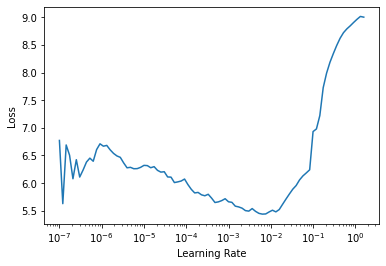

In [ ]:
learn.lr_find(suggestions=True)

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(4,
 tensor(5.4148, device='cuda:0', grad_fn=<NllLossBackward>),
 torch.Size([2, 63, 50265]))

# 아래 코드 실행시 오류 발생, 일단 100%까지 진행이 되는 걸로 봐서 가중치가 업데이트 되는 것 같기는 한데 애매하네요. 이건 제가 한번 더 확인해보겠습니다.

In [ ]:
learn.fit_one_cycle(1, lr_max=3e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,time


AttributeError: ignored

In [ ]:
learn.show_results(learner=learn, max_n=2)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,time


,text,target,prediction
0,"Tessy: Good morning Harry! Just thought I'd drop you a line before disappearing to the other side of the world. At the moment I'm on the train to Frankfurt airport, then off to Cuba for 5 weeks. Can't wait to be there!Harry: A very good morning to you dear Tessy! How nice you are in touch. So travelling again? Gosh, you've got stamina!Tessy: I wonder myself. Truth to tell I'm slightly apprehensive. Never been to Cuba. Have you?Harry: No, I'm not that adventurous but Maya was. Last summer with her boys. And I think she was very enthusiastic.But I remember no details. Why don't you ask her? She may have a tip or two.Tessy: A bit too late now :)) but I will definitely contact her. Still she can give me a few good tips. Do you remember if internet is really such a disaster there?Harry: Oh yes, it is. She was gone for 2 weeks and I heard from her twice: from the Havana airport when she arrived and on leaving.Tessy: I see! My Super Mario boss is expecting me to be online all the time - just in case. LOL","Tessy is going to Cuba for 5 weeks. She's staying in airbnb. Tessy is worried about the Internet connection, because her boss might contact her anytime. Harry wants to go to Israel for skiing holiday during Christmas. Tessy and Harry are going to meet in January.",Tessy is on her way to Cuba for 5 weeks. Harry is going to be online all the time. Maya was there last summer with her boys. Harry will contact Maya.
1,"Tommy: dudes, I have an idea for a larp.Aidy: go onConnor: let's hear it.Tommy: It would be about witches a'la new Sabrina, a coven meeting, modern style, but with a victorian twistSarah: sounds cuteTommy: you wanna know the twist?Aidy: bring it onTommy: there are 2 factions - one want's to talk about the future of the coven and are toward more civilized methods, the other is actually totally possessed by demons and wants the other half to sign a pact with them or - if nothing else works - kill them in the end.Connor: Cool. Does the 1st faction have any suspicion about what's going on?Tommy: Many people do, but it's not immediately knownAidy: Hm, might be a bit unbalanced - the 1st faction might be weaker than the 2ndSarah: what about a 3rd faction to balance it out?Tommy: like what?Sarah: demon hunters in disguise?Aidy: So then the duel is between the demons and the hunters and the people are still kinda weakTommy: They're still mages they can do a lot.Connor: I don't think the","Tommy has an idea for a new larp. It's about witches. There would be 2 factions, one of them possessed by demons. Sarah suggests adding a third faction of demon hunters. Sarah and Connor will help Tommy write it. Aidy is busy with her own project.","Tommy has an idea for a larp. It would be about witches a'la new Sabrina, a coven meeting, modern style, but with a victorian twist."


In [5]:
test_article = """
so I'm happy to report we have succeeded in rebooting our Flag ships way ahead of schedule yet again
 this is allowed us to improve I use fees by 90%
 that's nine out of every ten excellent thank you Samuel
 Timothy what's the status with a linear Solutions on the Square project Solutions department has yet again functions at full capacity and we have fulfilled 114% of this month's objectives you can read the handouts for a detailed account but in short Hazard reported last week we decided to use the right angle for the square project not the still some debate as to how big of a right angle is soap with testing currently at 9097 100 and 101 degrees as a great adventure Anderson cross-check the design removing any left angles and doesn't use them in future overall we have very good progress with the design are we on track for the schedule when we were required to stop delivering I'm happy to report that we are ready to start first deliveries tomorrow which is way ahead of the requested delivery schedule we've only just finished system testing the Prototype and only halfway through performance testing
 haven't even released an alfa Vision yet as I said I had very good progress with the design exactly that's three out of every four so we're ready to start shipping tomorrow
 BluePrint juice safe for units. Only shut the first three then when you're finally 100% complete with the design week and then ship the full
 excellent book Timothy you can proceed with the production is a revised delivery schedule so I can share it with a client well thank you everyone this was very pretty again
"""

In [ ]:
outputs = learn.blurr_generate(test_article, early_stopping=True, num_beams=4, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
 The past 12 months have been the worst for aviation fatalities so far this decade, with

=== Prediction 2 ===
 The past 12 months have been the worst for aviation fatalities so far this decade with the

=== Prediction 3 ===
 The past 12 months have been the worst for aviation fatalities, with the total of number



In [18]:
learn.metrics = None
#모델 저장
learn.export(fname='/content/drive/MyDrive/data/bart_pretrained_SAMsum.pkl')

In [19]:
inf_learn = load_learner(fname='/content/drive/MyDrive/data/bart_pretrained_SAMsum.pkl')
inf_learn.blurr_generate(test_article)

["Thank you everyone for your continued support.so I'm happy to report we have succeeded in rebooting our Flag ships way ahead of schedule yet again this is allowed us to improve I use fees by 90% so that's nine out of every ten excellent thank you Samuel and thank you Timothy what's the status with a linear Solutions on the Square project Solutions department has yet again functions at full capacity and we have fulfilled 114% of this month's objectives you can read the handouts for a detailed account but in short Hazard reported last week we decided to use the right angle for the square project not the still some debate as to how"]